# Machine Learning in Python - Project 2

Alfie Plant, Markus Emmott, Oscar Youngman, Ashe Raymond-Barker

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [4]:
from math import isnan

# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

#import keras
#import tensorflow as tf
# sklearn modules
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.preprocessing import Binarizer, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay

# EDA plotter functions

from helper_funcs import *

from geo_plotting_functions import *

from imblearn.over_sampling import RandomOverSampler, SMOTE

# Introduction

Brief discussion of problem and approaches used

### Data Overview

The dataset consists of 200,000 fully amortizing fixed-rate Single-Family mortgages. Of these, 125,959 have been paid off, 73,295 are still active, and 746 have defaulted. There are $32$ features, which can be categorised as follows:

 - **Personal Details:**
    - **fico** (Numeric): Borrower's credit score
    - **dti** (Numeric): Ratio value of borrower(s) monthly debt payments to total monthly income
    - **cnt_borr** (Categorical): Whether one of multiple borrowers are obligated to pay the mortgage: One borrower (1), Multiple borrowers (2)
    - **cltv** (Numeric): Ratio value of all combined loans of Borrower(s) to value of property
    - **ltv** (Numeric): Ratio value of mortgage loan of Borrower(s) to value of property
  
- **Loan Details:**
    - **dt_first_pi** (Numeric): First payment date of mortgage (YYYYMM)
    - **dt_matr** (Numeric): Final payment date of mortgage (YYYYMM)
    - **mi_pct** (Numeric): Percentage of loss coverage on the loan insurance plan, where 0 indicates no insurance
    - **orig_upb** (Numeric): Unpaid balance of mortgage to the nearest $1,000
    - **int_rt** (Numeric): Interest rate of loan
    - **channel** (Categorical): Indicates whether Broker or correspondent was involved in origination of mortgage loan: Retail(R), Broker(B), Correspondent(C)
    -  **loan_purpose** (Categorical): Indicates type of loan: Chash-out refinance mortgage(C), No cash-out refinance mortgage(N), Purchase mortgage(P)
    - **orig_loan_term** (Numeric): Number of scheduled monthly repayments on mortgage
    - **prod_type** (Categorical): Denotes whether mortgage is fixed rate or adjustable rate
    - **seller_name** (Categorical): Entity acting as seller of mortgages to Freddie Mac
    - **servicer_name** (Categorical): Entity acting as servicer of mortgages to Freddie Mac
    - **flag_sc** (Categorical): Indicates whether mortgages with origination dates after 10/1/2008, delived to Freddie Mac on or after 1/1/2009 exceed the conforming loan limits
    - **program_ind** (Categorical): Indicates whether loan is part of any programmes: Home Possible(H), HFA Advantage(F), Refi Possible(R) Not Available/Applicable(9)
    - **rr_ind** (Categorical): Indicates whether loan is part of Relief Refinance Program.
    - **io_ind** (Categorical): Indicates whether loan only requires interest payments for a specific period
    - **mi_cancel_ind** (Categorical): Indicates whether mortgage insurance has been reported as cancelled after time of Freddie Macs purchase of the mortgage loan: Cancelled(Y), Not Cancelled(N), Not Applicable(7), Not Disclosed(9)
    - **loan_status** (Categorical): Indicates whether borrower(s) has defaulted on loan, paid off loan or if loan is still active
  
- **Property Details:**
    - **flag_fthb** (Categorical): Indicates whether Borrower(s) is a purchasing mortgaged property as a primary residence, having had no ownership interest in a residential property in the three years prior: Yes(Y), No(N), Not available/applicable(9)
    - **cd_msa** (Categorical): Metropolitan Statistical Area (MSA) or Metropolitan Division
    - **cnt_units** (Ordinal)/(Categorical) Denotes number of units in property: One(1), Two(2), Three(3), Four(4), Not available(99)
    - **occpy_sts** (Categorical): Indicates status of property: Owner occupied(P), Second home(S), Investment property(I), Not available (9)
    - **st** (Categorical): Indicates State to which property belongs
    - **prop_type** (Categorical): Denotes property type: Condominium(CO), Planned unit development(PU), Cooperative share(CP), Manufactured home(MH), Single-family home(SF)
    - **zipcode** (Categorical): Postal code for location of mortgaged property
    - **property_val** (Categorical): Indicates method used to obtain property appraisal, if any: ACE Loans(1), Full Appraisal(2), Other Appraisals(3), ACE+PDR(4), Not Available(9)

The following columns from the data set have been removed since they do not offer any additional information:
- **ppmt_pnlty**, **io_ind** and **prod_type** are categorical features that only contain one value
- **id_loan_rr** can be removed since it is an indicator that is also given by **rr_ind**.
- **id_loan** ***we could keep this if we want to consider a comparison of the origination date and the first payment date***

In [5]:
d = pd.read_csv("freddiemac_extra2.csv", low_memory=False)
d = d.drop(columns=['id_loan_rr', 'io_ind', 'prod_type', 'ppmt_pnlty'])


### Missing Data

The data includes approximately 20,000 null values for the **cd_msa** information. Despite this, there is no missing information on **zipcode**. As a result, we have decided to use zipcode data in analysis. This will be discussed in more detail in exploratory data analysis.
The remaining features that contain null values are **flag_sc**, and **rr_ind**, however these are categorical variables that take NaN to refer to 'No'. All NaN entries have been replaced with 'N'.

There are 41 missing Credit Scores in the dataset. Out of these, 3 loans were defaults. Since the dataset does not contain many defaults, we do not want to exclude this information and we will proceed by ***add detail here...***. Only one observation is not available for the mortgage insurance percentage and given this loan was not a default, we will exclude it from the data set. There are 6 missing observations for combined loan-to-value, and 2 of these are the missing values for loan-to-value, which occurs when the loanee has no other loans. None of these loans were defaults, so they have been excluded.

There are 2,412 missing values for the debt-to-income ratio, and more notably, a disproportinal number of these observations are loans that have defaulted. When debt-to-income ratio is greater than 65%, it is classified as a missing value. These are loans where the monthly debt payments are greater than 65% of monthly income of the loanee suggesting that they are higher-risk loans. To deal with this we have discretised debt-to-income and encoded it ordinally. We have used cross-validation to determine a reasonable choice for the number of bins as 10.

We interpret the value of 9 for the program indicator as Not Applicable meaning that the loan is not part of a program. There could be missing data embedded within this, however since this category acts as a baseline associated to no programs, then this assumption does not lose any information. Finally, there are 125 values missing for property value. None of these are defaults, so they have been excluded.

In [6]:
d['flag_sc'] = d['flag_sc'].fillna('N')
d['rr_ind'] = d['rr_ind'].fillna('N')
d = d[d['fico'] != 9999] # removed missing credit scores for now but perhaps we should reconsider
d = d[d['mi_pct'] != 999]
d = d[d['cltv'] != 999]
d = d[d['property_val'] != 9]

### Feature Engineering
#### Date value changes
There are 3 instances of date values with the dataset: `dt_matr`, `dt_first_pi` and `id_loan`. For `dt_matr` and `dt_first_pi` we convert the dates to current year plus the fraction of how much of that year has progressed (e.g. 03/2024 -> 2024.25). For `id_loan` we have the year and the fiscal quarter, were the dates are in the same end format above with the month being the mid-point of the quarter (e.g. Q1 is (January to March) hence the month assigned is February).

In [7]:
date_str_to_num = np.vectorize(lambda x : int(str(x)[:-2])+(int(str(x)[-2:])-0.5)/12)
date_strq_to_num = np.vectorize(lambda x : 2000+int(x[1:3])+(int(x[4:5])*3-1)/12)

In [8]:
d["dt_first_pi"] = date_str_to_num(d["dt_first_pi"])
d["dt_matr"] = date_str_to_num(d["dt_matr"])
d["dt_logged"] = date_strq_to_num(d["id_loan"])

#### Banks
One issue we forsee arises with the two categorical variables: `seller_name` and `servicer_name`. Both have many values, and if one-hot encoded, would add a lot of sparse data attributes. Hence, we created a new metric to capture information about `seller_name` numerically (where we dropped `servicer_name`). This metric is mortgage "flexibility", the number of unique mortgage lengths for each seller, with the thought process being, "flexible" banks are likely to be bigger banks with better risk assessment.


This belief is reinforced in the data, by looking at the plot below; banks with lots of "flexibility" have a lower defaulting proportion.

In [9]:
bank_array = []

for bank in d["seller_name"].unique():
    if bank == "Other sellers":
        continue
    bank_data = d[d["seller_name"] == bank]
    flex = len(bank_data["orig_loan_term"].unique())
    default_prop = sum(bank_data["loan_status"]=="default")/len(bank_data["loan_status"])
    bank_array.append([bank, flex, default_prop])
    
bank_df = pd.DataFrame(bank_array, columns=["seller_name", "flex", "default_prop"])
other_banks = d[d["seller_name"] == "Other sellers"]
bank_df.loc[bank_df.shape[1]] = ["Other sellers", int(np.mean(bank_df["flex"])),
                                 sum(other_banks["loan_status"]=="default")/len(other_banks["loan_status"])]

flex_vector = []
for bank in d["seller_name"]:
    if bank == "UNITED SHORE FINANCIAL SERVICES, LLC, DBA UNITED WHOLESALE M":
        flex_vector.append(0.00786)
        continue
    flex_vector.append(bank_df[bank_df["seller_name"] == str(bank)]["flex"].values[0])
    
d["flex"] = flex_vector

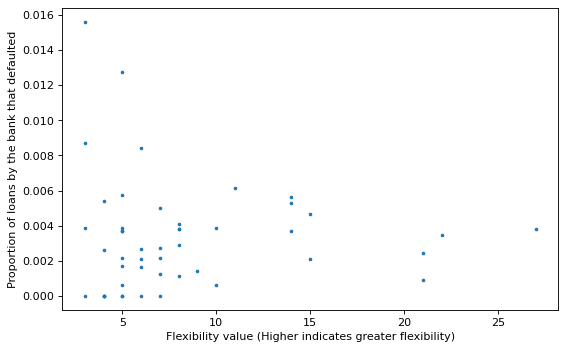

In [10]:
fig, ax = plt.subplots()

ax.scatter(bank_df["flex"], bank_df["default_prop"], s=5)
ax.set_xlabel("Flexibility value (Higher indicates greater flexibility)")
ax.set_ylabel("Proportion of loans by the bank that defaulted")
plt.show()

#### Geographical Data

The main two geographical attributes within the dataset are cd_msa and zipcode. In there current form they are categorical, with a large number of categories (448 unique cd_msa codes and 886 unique zipcodes). Ideally, we would like to encode geographical location numerically.

For each zipcode entry, we have the first 3 digits but the last two are excluded for privacy. A dataset was found of zipcodes, their latitude, longitude and population. For each entry in the dataset we took the beginning zipcode and assigned the final two digits based on a random sample weighted by proportion of zipcode population. Then with each sample having a unique, 6 digit zipcode, we assigned the observation the latitude and longitude value for this zipcode. This was carried out before splitting active and non-active.

In [11]:
counties, states = setup_map()

vals = d[["county_fips", "int_rt"]].groupby("county_fips").agg({"int_rt": "mean"}).reset_index()
fico_county = pd.DataFrame(vals)
counties_new = counties.reset_index().rename({"GEOID": "county_fips"}, axis="columns")
counties_new["county_fips"] = counties_new["county_fips"].astype("int64")
counties_new_fico = pd.merge(fico_county, counties_new, on="county_fips", how="left")
counties_new_fico = gpd.GeoDataFrame(counties_new_fico, geometry="geometry")

from shapely.geometry import Point

data_not_ah = d[~d["st"].isin(["MP", "GU", "AS"])]

long = data_not_ah["lng"]
lat = data_not_ah["lat"]
geometry = [Point(xy) for xy in zip(long, lat)]
values_for_df = pd.DataFrame({"geometry": geometry, "state": data_not_ah["st"]})
point_gdf = gpd.GeoDataFrame(values_for_df, geometry="geometry", crs="EPSG:4326")
point_gdf = point_gdf.to_crs("ESRI:102003")

point_gdf[point_gdf["state"] == "AK"] = \
    translate_geom(point_gdf[point_gdf["state"] == "AK"], 1100000, -4800000, 0.7, 32)
point_gdf[point_gdf["state"] == "HI"] = \
    translate_geom(point_gdf[point_gdf["state"] == "HI"], 5350000, -1500000, 1.5, 24)
point_gdf[point_gdf["state"] == "PR"] = \
    translate_geom(point_gdf[point_gdf["state"] == "PR"], -2500000, 300000, 3, 0)
background_color = "#242624"

sns.set_style({
    "font.family": "serif",
    "figure.facecolor": background_color,
    "axes.facecolor": background_color,
})

legend_kwds_colorbar = {"location": "bottom",
                        "orientation": "horizontal",
                        "fraction": 0.05,
                        "pad": 0.01,
                        "shrink": 0.5,
                        "drawedges": True,
                        "label": "Max Interest Rate"}

ax = counties_new_fico.plot(column="int_rt", cmap="YlGn", figsize=(20, 20), linewidth=0, legend=True,
                            legend_kwds=legend_kwds_colorbar)
states.plot(ax=ax, edgecolor="black", color="None", linewidth=0.4)
point_gdf[data_not_ah["loan_status"]=="default"].plot(ax=ax, color="white", linewidth=1, markersize=5, alpha=0.8, marker="^")
label_plot(ax)
ax.annotate("MEAN INTEREST RATE", (-1150000, -2020000), size=15, color="white", family="monospace")

plt.axis("off")
plt.rcParams.update({'xtick.color': "white",
                     "text.color": "white",
                     "legend.labelcolor": "white"})
plt.rcParams["figure.figsize"] = (8,10)
plt.show()

DataSourceError: C:\Users\emmot\DataspellProjects\ML_Proj2\cb_2018_us_county_500k: No such file or directory

### Data Split

***To avoid any data leakage, the dataset is split into training and test sets from this point onwards.***

We will separate active loans from non-active loans. The non-active loans will be separated a training set (70%) to build the model, a validation set to tune the model (15%), and finally a test set (15%). Once the final model has been determined, it will be used to offer insight on existing loans with Freddie Mac.

In [12]:
active = d[d['loan_status'] == 'active']
nonactive = d[d['loan_status'] != 'active']
nonactive = nonactive[[col for col in nonactive.columns if col != 'loan_status'] + ['loan_status']]


# Feature matrix and response vector
X, y = nonactive.drop(['loan_status'], axis=1), nonactive['loan_status']

# Convert to numpy array
X = X.values

# Encode default
y = LabelEncoder().fit_transform(y)

# Naively split the data into train and test sets 
X_train, X_tv, y_train, y_tv = train_test_split(X, y, shuffle= True,
                                                    test_size = 0.3, random_state=1112, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, shuffle= True,
                                                    test_size = 0.5, random_state=1112, stratify=y_tv)

# Convert back to DataFrame
df_train = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1, 1)], axis=1), columns=nonactive.columns)
df_test = pd.DataFrame(np.concatenate([X_test, y_test.reshape(-1, 1)], axis=1), columns=nonactive.columns)
df_val = pd.DataFrame(np.concatenate([X_test, y_test.reshape(-1, 1)], axis=1), columns=nonactive.columns)

# np.unique(y_train, return_counts=True)

# df_train.columns
nonactive.columns

Index(['fico', 'dt_first_pi', 'flag_fthb', 'dt_matr', 'cd_msa', 'mi_pct',
       'cnt_units', 'occpy_sts', 'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt',
       'channel', 'st', 'prop_type', 'zipcode', 'id_loan', 'loan_purpose',
       'orig_loan_term', 'cnt_borr', 'seller_name', 'servicer_name', 'flag_sc',
       'program_ind', 'rr_ind', 'property_val', 'mi_cancel_ind', 'zip', 'lng',
       'lat', 'county_fips', 'dt_logged', 'flex', 'loan_status'],
      dtype='object')

# Exploratory Data Analysis

### Categorical Data

In [13]:

plot_categorical(df_train, 'cnt_units')

NameError: name 'plot_categorical' is not defined

### Numerical Data

We check our assumptions for variables that would likely indicate someone to default or not, being the interest rate on their mortgage (int_rt) and fico score (fico). Looking at the heatmap below, we can see in green the heatmap of the entirety of the training dataset, laid onto is a heatmap of those who have defaulted. Clearly we can see the blue/default heatmap is centered on a low fico score (in comparison to the whole population) and at a higher interest rate than the main proportion seen in the entire dataset. 

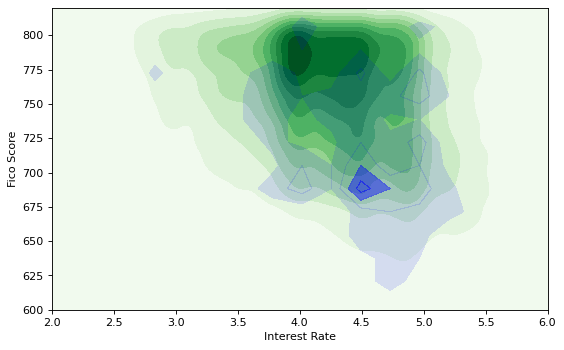

In [14]:
plot_heatmap(df_train, "int_rt", "fico")

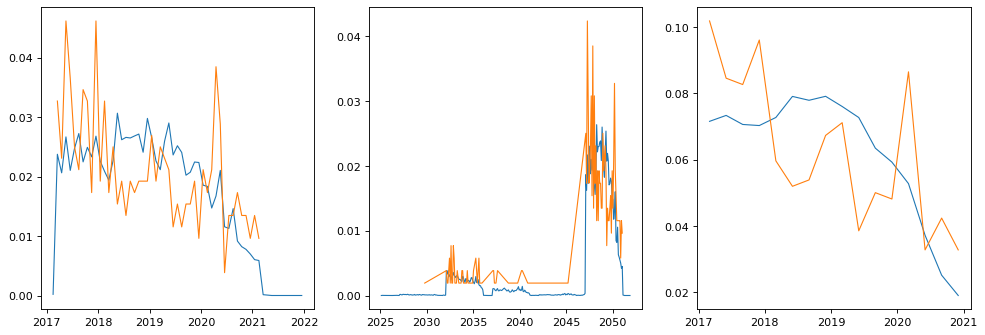

In [15]:

default_df = df_train[df_train["loan_status"]==0]
prepaid_df = df_train[df_train["loan_status"]==1]

fig, ax = plt.subplots(1,3, figsize = (15,5))

for i,var in enumerate(["dt_first_pi", "dt_matr", "dt_logged"]):
    dates_people_buy = np.unique(prepaid_df[var], return_counts=True)
    dates_people_buy_default = np.unique(default_df[var], return_counts=True)
    
    ax[i].plot(dates_people_buy[0], dates_people_buy[1]/sum(dates_people_buy[1]),
               linewidth=1)
    ax[i].plot(dates_people_buy_default[0], dates_people_buy_default[1]/sum(dates_people_buy_default[1]), linewidth=1)

## Pre-processing

In [ ]:
# Column Transformer Pipeline

dti_index = df_train.columns.get_loc("dti")
num_var = ["fico","dt_first_pi","dt_logged","flex","mi_pct","orig_upb","int_rt","dt_matr","cltv", "ltv", "orig_loan_term", "lat", "long"]
cat_var = ["flag_fthb", "cnt_units", "occpy_sts", "channel", "prop_type", "loan_purpose", "cnt_borr", "flag_sc", "program_ind", "rr_ind", "property_val", "mi_cancel_ind"]

num_var_index = df_train.columns.get_indexer(num_var)
cat_var_index = df_train.columns.get_indexer(cat_var)

ct = Pipeline(
    [("pre_processing", ColumnTransformer(
        [("disc", KBinsDiscretizer(encode='ordinal', n_bins=10), [dti_index]),
         ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), cat_var_index),
         ("num", StandardScaler(), num_var_index),
         ], remainder="drop",
    ))])

ct.fit(X_train)
X_train_e = ct.transform(X_train)

X_val_e = ct.transform(X_val)

### Dealing with Imbalance

Our task is a binary classifier and hence is highly sensitive to label imbalance. In the case of our dataset, this imbalance is vast. Particularly, we have very few instances of people who have defaulted. To combat this, we carry out resampling. There are two main methods, under- or oversampling; undersampling in our case is unfavorable as it removes a large quantity of observations for people who have prepaid their mortgages. Hence, we will be using oversampling.

Two main methods of oversampling are being considered:

- **Random oversampling** - where we resample from the subset of mortgages that default. Due to the size of the imbalance, these samples will have a large number of duplicates. This is not advantageous, as our model is likely to overfit due to the low variability in the subset of defaulting mortgages. (note: this can be mitigated by adjusting shrinkage, this will be explored).
- **SMOTE (_Synthetic Minority Oversampling Technique_)** - generates new synthetic observations via k nearest neighbours, randomly selects an observation. Finds the k nearest neighbours to this observation, chooses one at random and generates a new observation between itself and neighbour selected. This helps to avoid overfitting the data although will likely cause our dataset to misclassify those in the majority class (prepaid).

In [17]:
OS = RandomOverSampler(random_state=1112)
X_train_e_over, y_train_over = OS.fit_resample(X_train_e, y_train)

SMTE = SMOTE(random_state=1112)
X_train_e_smote, y_train_smote = SMTE.fit_resample(X_train_e, y_train)

/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public 

# Model Fitting and Tuning

### Logistic Regression
The performance of the logistic regression model is very poor with the relatively high recall rate of nearly 70% coming at the cost of extremely low precision of around 1.3%. This is made clear by the precision-recall curve, which shows performance which rapidly drops to the chance level. The poor performance of the model is likely due to overreliance on oversampling methods to improve the performance of the data on the small minority class of defaulters, and to the inflexibility of the model.
Comment on excluding Linear SVM due to poor performance of LogReg


### Non-Linear SVM

Try sparse input to deal with training time. If not, consider bagging. Experiment with poly, rbf, sigmoid, cosine and fine tune parameters.
Adapt loss function in GridSearch

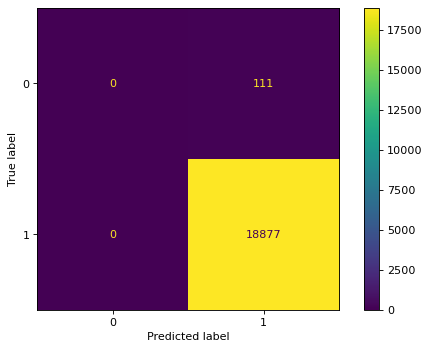

/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


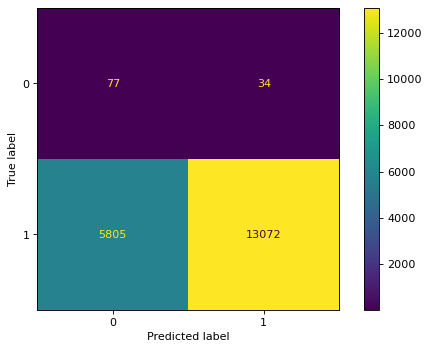

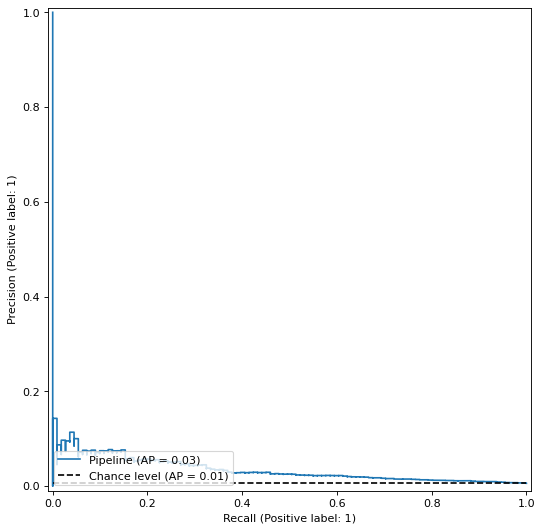

/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


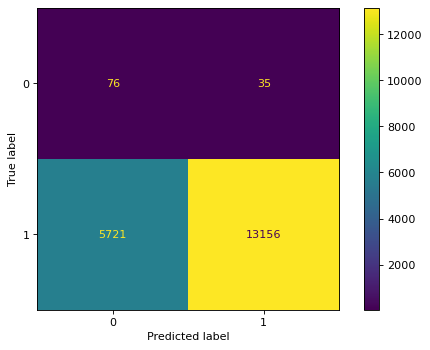

In [20]:
# Logistic regression Pipeline
log_pipe = make_pipeline(
    LogisticRegression(random_state=42, penalty=None)
)
X_test_e = ct.transform(X_test)
# Fit the model using the training data
log_pipe = log_pipe.fit(X_train_e, y_train)
ConfusionMatrixDisplay.from_estimator(log_pipe, X_test_e, y_test)
plt.show()

# Fit the model using the over-sampled training data
log_over = log_pipe.fit(X_train_e_over, y_train_over)
ConfusionMatrixDisplay.from_estimator(log_over, X_test_e, y_test)
plt.show()

# Plot the precision-recall curve with inverted labels

model_inverted = log_pipe.fit(X_test_e,1- y_test)
fig2, ax2 = plt.subplots(figsize=(8,8))
PrecisionRecallDisplay.from_estimator(model_inverted, X_test_e, 1- y_test, plot_chance_level=True, ax=ax2)
plt.show()

# Fit the model using the SMOTE training data
log_smote = log_pipe.fit(X_train_e_smote, y_train_smote)
ConfusionMatrixDisplay.from_estimator(log_smote, X_test_e, y_test)
plt.show()


In [ ]:
# Logistic regression Pipeline
log_pipe = make_pipeline(
    LogisticRegression(random_state=42, penalty=None)
)

# Fit the model using the training data
log_pipe = log_pipe.fit(X_train_e, y_train)
ConfusionMatrixDisplay.from_estimator(log_pipe, X_test_e, y_test)
plt.show()

# Fit the model using the over-sampled training data
log_over = log_pipe.fit(X_train_e_over, y_train_over)
ConfusionMatrixDisplay.from_estimator(log_over, X_test_e, y_test)
plt.show()

# Plot the precision-recall curve with inverted labels

model_inverted = log_pipe.fit(X_test_e,1- y_test)
fig2, ax2 = plt.subplots(figsize=(8,8))
PrecisionRecallDisplay.from_estimator(model_inverted, X_test_e, 1- y_test, plot_chance_level=True, ax=ax2)
plt.show()

# Fit the model using the SMOTE training data
log_smote = log_pipe.fit(X_train_e_smote, y_train_smote)
ConfusionMatrixDisplay.from_estimator(log_smote, X_test_e, y_test)
plt.show()

### Random Forests
Look through Ashe's work and integrate.
Feature Importance


### Neural Networks

We now consider neural network models. First starting with a simple baseline,


In [ ]:
input_shape = int(X_train_e.shape[1])

nn_model_base = keras.models.Sequential([
    keras.layers.Input((input_shape,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model_base.compile(loss='binary_crossentropy', metrics=['accuracy'])
history_base = nn_model_base.fit(X_train_e_smote, y_train_smote, epochs=10, validation_split=0.2)

In [ ]:
data_pairs = [(X_train_e, y_train),
              (X_train_e_over, y_train_over),
              (X_train_e_smote, y_train_smote),
              (X_val_e, y_val)]

data_pair_labels = ["Training data", "Oversampling data", "SMOTE data", "Validation data"]

produce_scoring(nn_model_base, data_pairs, data_pair_labels, threshold=0.5)

In [ ]:
produce_scoring(nn_model_base, data_pairs, data_pair_labels, threshold=0.8)

We can see based on the above that with a higher threshold for choosing the binary label from the probabilities provides better recall for observations within the recall class. This seems to suggest saturation within the neural network. Quickly checking the distributions of the attributes of X_train_e_smote we can see why this is likely, with lots of values within the numerical data columns lie far outside the interval of 0 to 1 (as our output is between 0 and 1 this is problematic). Hence, we carry out min-max scaling.

In [ ]:
# Fitting scaler.
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_e)

# Transforming our datasets.
X_train_e_nn = min_max_scaler.transform(X_train_e)
X_val_e_nn = min_max_scaler.transform(X_val_e)
X_train_e_smote_nn = min_max_scaler.transform(X_train_e_smote)
X_train_e_over_nn = min_max_scaler.transform(X_train_e_over)

data_pairs_nn = [(X_train_e_nn, y_train),
              (X_train_e_over_nn, y_train_over),
              (X_train_e_smote_nn, y_train_smote),
              (X_val_e_nn, y_val)]

In [ ]:
nn_model_base_mm = keras.models.Sequential([
    keras.layers.Input((input_shape,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model_base_mm.compile(loss='binary_crossentropy', metrics=['accuracy'])
history_base_mm = nn_model_base_mm.fit(X_train_e_smote_nn, y_train_smote, epochs=10, validation_split=0.2)

In [ ]:
produce_scoring(nn_model_base_mm, data_pairs_nn, data_pair_labels, threshold=0.5)

We see improvements on the validation set although this model now performs worse on the over set used to train. In order to further mitigate saturation we carry out the following:

 - **Batch Normalisation** (for each layer) - As our input and output values are within the range of 0 to 1, ideally our weights should be restricted to this interval. (_link paper that validates this is the correct approach_) Hence after each layer we normalise the weights. 
  - **He Normal initialization** - This set the initial values of each layer of weights to normal in distribution with some fixed variance (in the instance of this initialisation it is dependant on the number of neurons in the layer before the set of weights), this helps to mitigage exploding gradients and staturation (_link Glorot and Bengio paper_).
  - **Elu activation function** - This activation function is similar to standard ReLu although instead of flattening out to 0 when x is negative, it returns a negative value (closer to -1 as x tends to negative infinity), this helps to keep the layer values in a distribution with mean 0.

In [ ]:
nn_model_norm = keras.models.Sequential([
    keras.layers.Input((input_shape,)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(100, activation=None, kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model_norm.compile(loss='binary_crossentropy', metrics=['accuracy'])
history_norm = nn_model_norm.fit(X_train_e_smote_nn, y_train_smote, epochs=10, validation_split=0.2)

In [ ]:
produce_scoring(nn_model_norm, data_pairs_nn, data_pair_labels, threshold=0.5)

Now we run into a completely different issue, this model is heavily in favour of labelling samples as defaulting. This can be mitigated through the use of a different loss function, particular one that heavily penalises classifying those who don't default as default, a binary focal cross entropy loss function.

In [ ]:
nn_model_deep = keras.models.Sequential([
    keras.layers.Input((input_shape,)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(50, activation=None, kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(80, activation=None, kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(80, activation=None, kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(80, activation=None, kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(80, activation=None, kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(80, activation=None, kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(50, activation=None, kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])

loss_func = keras.losses.BinaryFocalCrossentropy(alpha=0.25, label_smoothing=0.2)
nn_model_deep.compile(loss=loss_func, optimizer="adam", metrics=['accuracy'])
history_deep = nn_model_deep.fit(X_train_e_smote_nn, y_train_smote, epochs=20, validation_split=0.2)

In [ ]:
produce_scoring(nn_model_deep, data_pairs_nn, data_pair_labels, threshold=0.9)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [2,4,6],
    'ccp_alpha': [0.003, 0.005, 0.01]
}

rf = RandomForestClassifier(random_state=1112, n_estimators=100)


rf_cv = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=3,
    scoring='f1',
    return_train_score=True
)

rf_cv.fit(X_train_e_smote, y_train_smote)

print("Best parameters:", rf_cv.best_params_)
print("Best cross-validated score:", rf_cv.best_score_)

In [ ]:
rf_model = RandomForestClassifier(max_depth=3, random_state=1112, n_estimators=100).fit(X_train_e_smote, y_train_smote)
y_pred_rf = rf_model.predict(X_val_e)
confusion_matrix(y_val, y_pred_rf)

In [ ]:
y_pred_nn = nn_model_deep.predict(X_val_e)
y_pred_rf = rf_model.predict_proba(X_val_e)

In [ ]:
(y_pred_nn[:,0]).dot(y_pred_rf[:,1])/(np.linalg.norm(y_pred_nn[:,0])*np.linalg.norm(y_pred_rf[:,1]))
            




### Final Model
Discussion and Results of final choices

In [ ]:
y_pred_nn = np.random.uniform(size=1000, low=0, high=1)
y_pred_rf = np.random.uniform(size=1000, low=0, high=1)
y_true = np.random.uniform(size=1000, low=0, high=1)


### Active Loans
Bank rating
Heatmap of location risk



# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb